In [1]:
import os
import itertools
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.timeseries import LombScargle
from pmdarima.arima import auto_arima

from ruptures import Pelt
from scipy.signal import welch
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss,q_stat
from statsmodels.tsa.seasonal import STL
from scipy.stats import probplot, moment
from statsmodels.stats.diagnostic import het_arch
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import ipywidgets as widgets

import ruptures as rpt

%matplotlib inline

warnings.filterwarnings("ignore")

General

In [2]:
def save_plot(title, plot_name, fig=None):
    if not fig:
        fig = plt.gcf()

    # Create the EDA directory if it doesn't exist
    if not os.path.exists('EDA'):
        os.makedirs('EDA')

    # Create the subdirectory for the series if it doesn't exist
    series_path = f'EDA/{title}'
    if not os.path.exists(series_path):
        os.makedirs(series_path)

    # Save the plot in the corresponding subdirectory with the plot_name in the file name
    fig.savefig(f'{series_path}/{plot_name}.png')
    plt.close()

## Analysis

Seasonality

In [3]:
# Decompose the given time series into trend, seasonal, and residual components
def decompose(series, frequency, title, figsize=(20, 12)):
    frequency_int = {
        'H': 24,  # hours in a day
        'D': 7,   # days in a week
        'W': 52,  # weeks in a year
        'M': 12,  # months in a year
    }
    
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=figsize)

    decomposition = STL(series, period=frequency_int[frequency], robust=True)
    result = decomposition.fit()
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    axs[0].plot(series)
    axs[0].set_ylabel('Observed')

    axs[1].plot(trend)
    axs[1].set_ylabel('Trend')

    axs[2].plot(seasonal)
    axs[2].set_ylabel('Seasonal')
 
    axs[3].scatter(series.index, residual)
    axs[3].set_ylabel('Residual')

    fig.suptitle(title+' '+frequency, fontsize=14)
    fig.tight_layout()
    save_plot(series.name, f'seasonal_decomposition_{frequency}')


Perdiodicty

In [4]:
def plot_power_spectral_density(ts, frequency, title):
    freqs, psd = welch(ts)
    plt.plot(freqs, psd)
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density')
    plt.title(title)
    
    save_plot(ts.name, f'power_spectral_density_{frequency}')

def plot_lomb_scargle_periodogram(ts,frequency, title):
    time = np.arange(len(ts))
    ls = LombScargle(time, ts)
    freq, power = ls.autopower()
    plt.plot(freq, power)
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title(title)

    save_plot(ts.name, f'lomb_scargle_periodogram_{frequency}')

def plot_acf_pacf(data,frequency, title, max_lags=None):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot ACF
    plot_acf(data, lags=max_lags, ax=axes[0], alpha=0.05)
    axes[0].set_ylabel('ACF')

    # Plot PACF
    plot_pacf(data, lags=max_lags, ax=axes[1], alpha=0.05)
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('PACF')

    fig.suptitle(title)

    save_plot(data.name, f'acf_pacf_{frequency}', fig)

def autocorrelation_test(series, lags=10):
    lags = min(10, int(series.size)/5) if lags is None else lags
    if series.empty or series.size < lags:
        print(f"Cannot perform Ljung-Box test: series is empty or has less than {lags} observations.")
        return None

    stats = sm.stats.acorr_ljungbox(series, lags=lags, auto_lag=True)
    return stats['lb_pvalue']


def spectral_analysis(series, title, freq_list=['H', 'D', 'W', 'M']):
    # Loop over each frequency
    for freq in freq_list:
        # Resample original data
        resampled_data = series.resample(freq).mean()
        print(len(resampled_data))
        print('Resampled data for frequency:', freq)
        # Analyse power spectral density and Lomb-Scargle periodogram
        # plot_power_spectral_density(resampled_data,freq, title)
        plot_lomb_scargle_periodogram(resampled_data,freq, title)
        # Analyse ACF and PACF plots
        plot_acf_pacf(resampled_data,freq, title)
        try:
            autocorr_test_result = autocorrelation_test(resampled_data, lags=10)
            if autocorr_test_result is not None:
                print(autocorr_test_result)
            else:
                print("The input series is empty.")
        except:
            print("The input series is empty.")
            
            


Statistics

In [22]:
def display_data_statistics(df):
    print("Mean:\n", df.mean())
    print("Variance:\n", df.var())
    print("Covariance:\n", df.cov())

def analyse_kolmogorov_smirnov(df):
    for col in df.columns:
        h, p = stats.kstest(df[col], 'norm')
        if p < 0.05:
            print(f"Kolmogorov-Smirnov test for '{col}': The distribution is not normal (p-value = {p})")
        else:
            print(f"Kolmogorov-Smirnov test for '{col}': The distribution is normal (p-value = {p})")

def analyse_skewness_kurtosis(df):
    for col in df.columns:
        skew = stats.skew(df[col])
        kurt = stats.kurtosis(df[col])
        print(f'Skewness for {col}: {skew}')
        print(f'Kurtosis for {col}: {kurt}')

def analyse_normality(df):
    analyse_kolmogorov_smirnov(df)
    analyse_skewness_kurtosis(df)

def plot_rolling_statistics(ts, title, window=120, alpha=0.6):
    rolmean = ts.rolling(window=window).mean()
    rolstd = ts.rolling(window=window).std()

    plt.plot(ts, color='blue', label='Original', alpha = 0.5)
    plt.plot(rolmean, color='orange', label='Rolling Mean', alpha=0.8)
    plt.plot(rolstd, color='green', label='Rolling Std', alpha=0.6)
    plt.legend(loc='best')
    plt.title(f'Rolling Mean and Standard Deviation of {title}')
    save_plot(ts.name, f'Rolling Mean and Standard Deviation_{title}')

def adf_test_fast(ts):
    return adfuller(ts)

def kpss_test_fast(ts):
    return kpss(ts)

def test_stationarity(ts):
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test_results = adf_test_fast(ts.values)
    adf_output = pd.Series(adf_test_results[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adf_test_results[4].items():
        adf_output[f'Critical Value ({key})'] = value
    print(adf_output)

    print('\nResults of Kwiatkowski-Phillips-Schmidt-Shin Test:')
    kpss_test_results = kpss_test_fast(ts.values)
    kpss_output = pd.Series(kpss_test_results[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpss_test_results[3].items():
        kpss_output[f'Critical Value ({key})'] = value
    print(kpss_output)

    if adf_test_results[1] < 0.05:
        print(f"The time series '{ts.name}' is stationary based on the Augmented Dickey-Fuller test.")
    else:
        print(f"The time series '{ts.name}' is not stationary based on the Augmented Dickey-Fuller test.")

    if kpss_test_results[1] < 0.05:
        print(f"The time series '{ts.name}' is not stationary based on the Kwiatkowski-Phillips-Schmidt-Shin test.")
    else:
        print(f"The time series '{ts.name}' is stationary based on the Kwiatkowski-Phillips-Schmidt-Shin test.")
    
def plot_hist_kde(data, cutoff_percentile=99.99):
    cutoff_value = np.percentile(data, cutoff_percentile)
    filtered_series = data[data <= cutoff_value]
    
    # Histogram with smaller bins
    fig_hist, ax_hist = plt.subplots(figsize=(10, 7))
    sns.histplot(data=filtered_series, kde=True, bins=100, ax=ax_hist)
    ax_hist.set_xlabel('')
    ax_hist.set_title(f'Histogram of {data.name}')
    ax_hist.grid()
    ax_hist.set_ylim(0, ax_hist.get_ylim()[1] * 0.17)  # Rescale the y-axis
    save_plot(data.name, f'Histogram_{data.name}')
    
def plot_box_daily(df):
    df_ = df.copy()
    df_ = df_.resample('D').mean()
    df_.boxplot( grid=False)
    plt.title("Daily log-returns")
    save_plot("", f'Daily log-returns Box plot')   
    
def autocorrelation_plots(data, lags):
    columns = [data]
    for i in range(1, lags + 1):
        columns.append(data.shift(i))

    dataframe = pd.concat(columns, axis=1)
    column_names = ['t']
    for i in range(1, lags + 1):
        column_names.append('t-' + str(i))
    dataframe.columns = column_names

    plt.figure(figsize=(15, 8))
    for i in range(1, lags + 1):
        ax = plt.subplot(2, 4, i)
        ax.set_title('t vs t-' + str(i))
        plt.scatter(x=dataframe['t'].values, y=dataframe['t-' + str(i)].values)

    save_plot(data.name, f'Autocorrelation plots_{data.name}')
    


Volatility

In [6]:
def assess_volatility_clustering(ts):
    squared_returns = ts.pow(2)
    absolute_returns = np.abs(ts)

    perform_arch_lm_test(squared_returns, "Squared Returns")
    perform_ljung_box_test(squared_returns, "Squared Returns")

    perform_arch_lm_test(absolute_returns, "Absolute Returns")
    perform_ljung_box_test(absolute_returns, "Absolute Returns")


def perform_arch_lm_test(returns, return_type):
    test_stat, p_value, f_stat, f_p_value = het_arch(returns)
    if p_value < 0.05:
        print(f"ARCH-LM test ({return_type}): p-value = {p_value:.4f} < 0.05, reject null hypothesis of homoskedasticity.\n")
    else:
        print(f"ARCH-LM test ({return_type}): p-value = {p_value:.4f} >= 0.05, fail to reject null hypothesis of homoskedasticity.\n")


def perform_ljung_box_test(returns, return_type):
    try: 
        ljung_resid = autocorrelation_test(returns)
        print(f'Ljung-Box test for {return_type} Residuals:', ljung_resid)
        print('\n')
    except: 
        print(f'Ljung-Box test for {return_type} Residuals: Cannot be computed.')
        print('\n')


def plot_volatility_clustering(ts):
    squared_returns = ts**2
    absolute_returns = np.abs(ts)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    axs[0].plot(squared_returns)
    axs[0].set_xlabel('Time')
    axs[0].set_title("Squared Returns")
    axs[1].plot(absolute_returns)
    axs[1].set_xlabel('Time')
    axs[1].set_title("Absolute Returns")
    save_plot(ts.name, f'Volatility Clustering_{ts.name}')


Outlier analysis

In [15]:
def print_series_comparison_info(s1, s2, s1_outliers=None, s2_outliers=None):
    # Calculate the number of non-NaN values in each series
    s1_count = s1.value_counts().sum()
    s2_count = s2.value_counts().sum()
    
    # Calculate the number of non-NaN values in each outlier series
    if s1_outliers is not None:
        s1_outliers_count = s1_outliers.value_counts().sum()
    else:
        s1_outliers_count = 0
        
    if s2_outliers is not None:
        s2_outliers_count = s2_outliers.value_counts().sum()
    else:
        s2_outliers_count = 0
    
    # Calculate the number of non-NaN values in the intersection of the outlier series
    if s1_outliers is not None and s2_outliers is not None:
        intersection = intersect_non_nan(s1_outliers, s2_outliers)
        intersection_count = intersection.value_counts().sum()
        plot_series_with_outliers(s1, s1,intersection, 'Series 1')
        plot_series_with_outliers(s2, s2,intersection, 'Series 2')
        
        # Print the intersection times
        print("Intersection times:")
        print(intersection.dropna())
    else:
        intersection_count = 0
    
    # Print the results
    print(f"Series 1 non-NaN count: {s1_count}")
    print(f"Series 2 non-NaN count: {s2_count}")
    print(f"Series 1 outliers count: {s1_outliers_count}")
    print(f"Series 2 outliers count: {s2_outliers_count}")
    print(f"Intersection of outlier series count: {intersection_count}")
    
def intersect_non_nan(s1, s2):
    """Return the intersection of two series, ignoring NaN values."""
    return s1.loc[s1.notna()].index.intersection(s2.loc[s2.notna()].index)

def standardize_series(series):
    return StandardScaler().fit_transform(series.values.reshape(-1, 1))

def apply_dbscan_clustering(series_standardized, eps=0.5, min_samples=2):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(series_standardized)

def extract_outliers_from_clusters(series, clusters):
    """Identify the outliers (cluster label -1 indicates an outlier)"""
    return series[clusters == -1]

def cluster_based_outlier_detection(series):
    series_standardized = standardize_series(series)
    clusters = apply_dbscan_clustering(series_standardized, eps=0.15)
    outliers = extract_outliers_from_clusters(series, clusters)
    return outliers

# def plot_series_with_outliers(series, outliers, title):
#     plt.plot(series)
#     outlier_indices = series[series.isin(outliers)].index
#     plt.scatter(outlier_indices, series.loc[outlier_indices], color='red', marker='o')
#     plt.xlabel('Time')
#     plt.ylabel('Price')
#     plt.title(f'{title} with Outliers Highlighted')
#     plt.show()
#     save_plot(title, f'Outliers_{title}')

def plot_series_with_outliers(series, detection_series, outliers, title):
    plt.plot(series)
    outlier_indices = detection_series[detection_series.isin(outliers)].index
    plt.scatter(outlier_indices, series.loc[outlier_indices], color='red', marker='o', label='Outliers')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'{title} with Outliers Highlighted')
    save_plot(series.name, f'Outliers_{title}')

Main functions


In [26]:
def analyse_seasonality(series, title, freq_list=['H', 'D', 'W', 'M']):
    # Loop over each frequency
    for freq in freq_list:
        # Resample original data
        resampled_data = series.resample(freq).mean()

        # Perform seasonal decomposition
        decompose(resampled_data, freq, title)

def analyse_distribution(df):
    # Display data statistics
    print("Data statistics:")
    display_data_statistics(df)
    
    ONE_HOUR = 120
    # Plot rolling statistics
    for col in df.columns:
        print(f"Rolling statistics of {col}:")
        plot_rolling_statistics(df[col], col,window=ONE_HOUR)
        
    # Plot box, histogram, and KDE
    for col in df.columns:
        print(f"Distribution analysis of {col}:")
        plot_hist_kde(df[col])
     
    #plot boxplot
    plot_box(df)
           
    # analyse normality
    print("Normality analysis:")
    analyse_normality(df)
    
    # Test stationarity
    for col in df.columns:
        print(f"Stationarity of {col}:")
        # test_stationarity(df[col])
        
def assess_and_plot_volatility_clustering(rt):
    plot_volatility_clustering(rt)
    # assess_volatility_clustering(rt)
    
def plot_series_and_returns(ts, title):
    # Calculate log returns and squared log returns
    returns = calculate_log_returns(ts)
    squared_log_returns = returns**2

    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

    # Plot time series
    axes[0].plot(ts)
    axes[0].set_title(f'{title} - Time Series')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Value')

    # Plot log returns
    axes[1].plot(returns)
    axes[1].set_title(f'{title} - Log Returns')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Log Returns')

    # Plot squared log returns
    axes[2].plot(squared_log_returns)
    axes[2].set_title(f'{title} - Squared Log Returns')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Squared Log Returns')

    # Adjust layout and display plot
    plt.tight_layout()
    save_plot(title, f'Series Plots_{title}')   
    
def plot_normalised_price(ts_1,ts_2):
    df = pd.concat([ts_1, ts_2], axis=1)
    scaled_df = scale(df)
    scaled_df.columns = ['ts1', 'ts2']
    scaled_df.plot()
    plt.title('Prices scaled')    
    save_plot("", f'Normliased Prices')
        
def analyse_outliers(rt1, rt2, frequency):
    # Calculate squared returns for both series
    squared_rt1 = rt1.pow(2)
    squared_rt2 = rt2.pow(2)
    
    # Perform cluster-based outlier detection for both series
    outliers_rt1 = cluster_based_outlier_detection(squared_rt1)
    outliers_rt2 = cluster_based_outlier_detection(squared_rt2)

    # Print the number of outliers detected in the volatility of both series
    print(f"Number of outliers in volatility of ts1: {len(outliers_rt1)}")
    print(f"Number of outliers in volatility of ts2: {len(outliers_rt2)}")

    # Plot returns with outliers calculated from the squared returns for both series
    plot_series_with_outliers(rt1, squared_rt1, outliers_rt1, f'{rt1.name} {frequency} Returns')
    plot_series_with_outliers(rt2, squared_rt2, outliers_rt2, f'{rt2.name} {frequency} Returns')

    # Plot squared returns with outliers for both series
    plot_series_with_outliers(squared_rt1, squared_rt1, outliers_rt1, f'{rt1.name} {frequency} Volatility')
    plot_series_with_outliers(squared_rt2, squared_rt2, outliers_rt2, f'{rt2.name} {frequency} Volatility')
   
    #check for common outliers
    print_series_comparison_info(rt1, rt2, outliers_rt1, outliers_rt2)
    
    
def analyse_time_series(ts1, ts2, rt1, rt2):
    print("Seasonality analysis for ts1:")
    analyse_seasonality(ts1, 'ts1', freq_list=['H', 'D', 'W'])
    
    print("Seasonality analysis for ts2:")
    analyse_seasonality(ts2, 'ts2', freq_list=['H', 'D', 'W'])
    
    # print("Spectral analysis for rt1:")
    # spectral_analysis(rt1, 'ts1', freq_list=['H', 'D', 'W'])
    
    # print("Spectral analysis for rt2:")
    # spectral_analysis(rt2, 'ts2', freq_list=['H', 'D', 'W'])
    
    # rt = pd.concat([rt1, rt2], axis=1)
    # print("Distribution analysis for log returns:")
    # analyse_distribution(rt)
    
    # print("Volatility clustering analysis for rt1:")
    # assess_and_plot_volatility_clustering(rt1)
    
    # print("Volatility clustering analysis for rt2:")
    # assess_and_plot_volatility_clustering(rt2)
    
    # print("Outlier analysis for rt1 and rt2:")
    # rt1_d = rt1.resample('H').mean().dropna()
    # rt2_d = rt2.resample('H').mean().dropna()
    # analyse_outliers(rt1_d, rt2_d, 'Hourly')
    # rt1_d = rt1.resample('D').mean().dropna()
    # rt2_d = rt2.resample('D').mean().dropna()
    # analyse_outliers(rt1_d, rt2_d, 'Daily')


Prepare data

In [23]:
def load_clean_data(filename):
    clean_df = pd.read_csv(filename)
    clean_df.columns = ['datetime', 'ts1_imputed', 'ts2_imputed']
    clean_df.set_index('datetime', inplace=True)
    clean_df.index = pd.to_datetime(clean_df.index)
    return clean_df

def calculate_log_returns(df):
    rt = np.log(df / df.shift(1))
    rt.dropna(inplace=True)
    return rt

def load_raw_data(filename):
    raw_df = pd.read_csv(filename, header=None)
    raw_df.columns = ['datetime', 'ts1_raw', 'ts2_raw']
    raw_df['datetime'] = pd.to_datetime(raw_df['datetime'] - 719529, unit='d').round('s')
    raw_df.set_index('datetime', inplace=True)
    raw_df.dropna(inplace=True)
    return raw_df

def load_data_and_calculate_returns(filename, imputed=False):
    if imputed:
        df = load_clean_data(filename)
        ts_1, ts_2 = df['ts1_imputed'], df['ts2_imputed']
        rt = calculate_log_returns(df)
        rt_1, rt_2 = rt['ts1_imputed'], rt['ts2_imputed']
    else:
        df = load_raw_data(filename)
        ts_1, ts_2 = df['ts1_raw'], df['ts2_raw']
        rt = calculate_log_returns(df)
        rt_1, rt_2 = rt['ts1_raw'], rt['ts2_raw']

    return ts_1, ts_2, rt_1, rt_2

def scale(df):
    df_ = df.copy()
    for i in df_.columns[0:]:
        df_[i] = (df_[i]-df_[i].mean())/df_[i].std()
    return df_

Main

In [12]:
# Load imputed data and calculate returns
ts_1, ts_2, rt_1, rt_2 = load_data_and_calculate_returns('interpolate_clean_df.csv', imputed=True)
# Load non-imputed data and calculate returns
ts1_o, ts2_o, rt_1_o, rt_2_o = load_data_and_calculate_returns("Test_data.csv", imputed=False)

#plot normalised time series
plot_normalised_price(ts1_o, ts2_o)

# non-imputed data
plot_series_and_returns(ts1_o, 'ts1_raw')
plot_series_and_returns(ts2_o, 'ts2_raw')
#imputed data
plot_series_and_returns(ts_1, 'ts1_imputed')
plot_series_and_returns(ts_2, 'ts2_imputed')

#analyse time series
# non-imputed data
analyse_time_series(ts1_o, ts2_o, rt_1_o, rt_2_o)
#imputed data
analyse_time_series(ts_1, ts_2, rt_1, rt_2)

Seasonality analysis for ts1:
Seasonality analysis for ts2:
Seasonality analysis for ts1:
Seasonality analysis for ts2:


In [27]:
plot_normalised_price(ts1_o, ts2_o)

In [16]:
# Load imputed data and calculate returns
ts_1, ts_2, rt_1, rt_2 = load_data_and_calculate_returns('interpolate_clean_df.csv', imputed=True)
# Load non-imputed data and calculate returns
ts1_o, ts2_o, rt_1_o, rt_2_o = load_data_and_calculate_returns("Test_data.csv", imputed=False)
print("Outlier analysis for rt1 and rt2:")
rt_1_o = rt_1_o.resample('D').mean().dropna()
rt_2_o = rt_2_o.resample('D').mean().dropna()
analyse_outliers(rt_1_o, rt_2_o, 'Daily')

In [ ]:
#Normalise data
def scale(df):
  df_ = df.copy()
  for i in df_.columns[0:]:
    df_[i] = (df_[i]-df_[i].mean())/df_[i].std()
  return df_


ts_o = pd.concat([ts1_o, ts2_o], axis=1)
rt_o = pd.concat([rt_1_o, rt_2_o], axis=1)
scaled_df = scale(ts_o)
scaled_df.columns = ['ts1', 'ts2']
scaled_df.plot()
plt.title('Prices scaled')
plt.show()

rt_o.columns = ['ts1', 'ts2']
rt_o.resample('D').mean().boxplot( grid=False)
# rt_o.boxplot( grid=False)
plt.title("Daily log-returns")
plt.show()

In [19]:
rt_o = pd.concat([rt_1_o, rt_2_o], axis=1)
rt_o.resample('D')
rt_o

,ts1_raw,ts2_raw
datetime,,
2008-01-01,-1.659310e-05,0.000070
2008-01-02,8.087526e-06,0.000099
2008-01-03,1.907706e-06,-0.000027
2008-01-04,6.951822e-06,-0.000155
2008-01-06,-4.896960e-06,-0.000013
...,...,...
2012-12-26,7.351323e-06,-0.000084
2012-12-27,7.350188e-07,0.000002
2012-12-28,-2.408836e-19,0.000005


In [21]:
def plot_box(df):
    df.boxplot( grid=False)
    plt.title("Daily log-returns")
    save_plot("", f'Daily log-returns Box plot')   
    
plot_box(rt_o)

In [35]:
def plot_volatility_clustering(ts):
    squared_returns = ts**2
    absolute_returns = np.abs(ts)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    axs[0].plot(squared_returns)
    axs[0].set_xlabel('Time')
    axs[0].set_title("Squared Returns")
    axs[1].plot(absolute_returns)
    axs[1].set_xlabel('Time')
    axs[1].set_title("Absolute Returns")
    # save_plot(ts.name, f'Volatility Clustering_{ts.name}')
    plt.show()

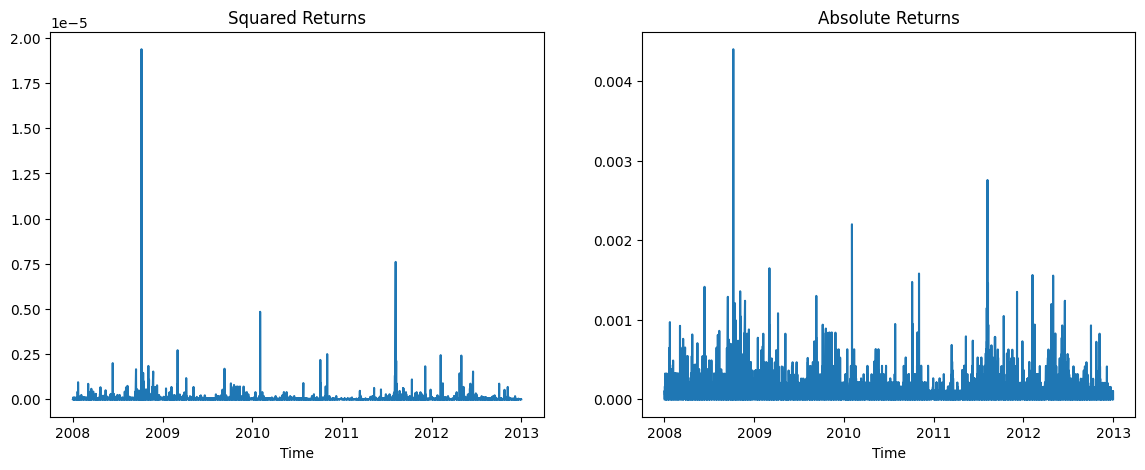

In [36]:
plot_volatility_clustering(rt_1_o)

In [ ]:
def plot_series_with_outliers(series, detection_series, outliers, title):
    plt.plot(series)
    outlier_indices = detection_series[detection_series.isin(outliers)].index
    plt.scatter(outlier_indices, series.loc[outlier_indices], color='red', marker='o', label='Outliers')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'{title} with Outliers Highlighted')
    save_plot(series.name, f'Outliers_{title}')

In [30]:
# def plot_series_with_outliers(series, detection_series, outliers, title):
#     plt.plot(series)
#     outlier_indices = detection_series[detection_series.isin(outliers)].index
#     plt.scatter(outlier_indices, series.loc[outlier_indices], color='red', marker='o')
#     plt.xlabel('Time')
#     plt.ylabel('Price')
#     plt.title(f'{title} with Outliers Highlighted')
#     save_plot(title, f'Outliers_{title}')
#     plt.show()

# rt_1_d = rt_1.resample('D').mean()
# rt_2_d = rt_2.resample('D').mean()

# # Cluster outlier detection method rt_1
# co_1 = cluster_based_outlier_detection(rt_1_d.pow(2))
# print(len(co_1))

# # Plot returns with outliers calculated from the squared returns
# plot_series_with_outliers(rt_1_d, rt_1_d.pow(2), co_1, 'ts1')

# # Plot squared returns with outliers
# plot_series_with_outliers(rt_1_d.pow(2), rt_1_d.pow(2), co_1, 'Volatility ts1')


In [ ]:
def calculate_log_returns(df):
    rt = np.log(df / df.shift(1))
    rt.dropna(inplace=True)
    return rt

squared_returns = ts**2


import matplotlib.pyplot as plt
import numpy as np




In [ ]:
# load imputed data to analyse
clean_df = load_clean_data('clean_df.csv')
ts_1_imp, ts_2_imp = clean_df['ts1'], clean_df['ts2']
rt = calculate_log_returns(clean_df)
rt_1, rt_2 = rt['ts1'], rt['ts2']


#load non imputed data to analyse
raw_df = load_raw_data("Test_data.csv")
ts1, ts2 = raw_df['ts1'], raw_df['ts2']
rt_o = calculate_log_returns(raw_df)
rt_1_o, rt_2_o = rt_o['ts1'], rt_o['ts2']


Analyse seasonality and periodicity

In [8]:
clean_df = pd.read_csv('clean_df.csv')
clean_df.set_index('datetime', inplace = True)
clean_df.index = pd.to_datetime(clean_df.index)
ts_1_imp = clean_df['ts1']
ts_2_imp = clean_df['ts2']

rt = np.log(clean_df/clean_df.shift(1))
rt.dropna(inplace=True)
rt_1 = rt['ts1']
rt_2 = rt['ts2']

In [9]:
analyse_seasonality(ts_1_imp, 'ts1', freq_list=['H', 'D', 'W'])
analyse_seasonality(ts_2_imp, 'ts2', freq_list=['H', 'D', 'W'])
spectral_analysis(rt_1, 'ts1', freq_list=['30T','H', 'D', 'W'])
spectral_analysis(rt_2, 'ts2', freq_list=['15T','30T','H', 'D', 'W'])

87697
Resampled data for frequency: 30T
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
1342    0.0
1343    0.0
1344    0.0
1345    0.0
1346    0.0
Name: lb_pvalue, Length: 1346, dtype: float64
43849
Resampled data for frequency: H
1      1.902746e-102
2      3.428267e-103
3      2.302631e-141
4      3.898554e-141
5      5.060247e-140
           ...      
673    6.598688e-276
674    1.281126e-275
675    1.329454e-276
676    2.148532e-276
677    7.206992e-277
Name: lb_pvalue, Length: 677, dtype: float64
1828
Resampled data for frequency: D
1     2.749358e-08
2     1.209098e-08
3     5.252480e-10
4     2.206219e-09
5     1.977099e-12
6     2.981798e-12
7     1.183828e-12
8     3.668346e-15
9     7.754188e-15
10    1.939658e-14
11    5.939334e-14
12    1.494105e-13
13    1.491725e-13
14    8.296106e-14
15    1.768018e-13
16    4.318002e-13
17    7.293159e-13
18    7.302109e-13
19    4.877019e-13
20    4.842432e-13
21    1.316254e-14
22    3.113551e-14
23    6.86306

ValueError: zero-size array to reduction operation maximum which has no identity

Analyse returns statistics

In [ ]:
analyse_distribution(rt)
plot_volatility_clustering(rt_1)
assess_volatility_clustering(rt_1)
plot_volatility_clustering(rt_2)
asses_volatility_clustering(rt_2)

In [13]:
##apply stats to non imputed and imputed data
#non imputed
def load_data(filename):
    raw_df = pd.read_csv(filename, header=None)
    raw_df.columns = ['datetime', 'ts1', 'ts2']
    raw_df['datetime'] = pd.to_datetime(raw_df['datetime']-719529,unit='d').round('s')
    raw_df.set_index('datetime', inplace=True)
    return raw_df

filename = "Test_data.csv"
raw_df = load_data(filename)
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']
rt_o = np.log(raw_df/raw_df.shift(1))
# rt.dropna(inplace=True)
rt_1_o = rt_o['ts1']
rt_2_o = rt_o['ts2']

Returns volatility clustering

Outlier analysis

In [23]:
def peaks_over_threshold(series, threshold_quantile=0.95):
    # Choose a high threshold using the quantile
    threshold = np.quantile(series, threshold_quantile)
    # Identify the exceedances and their corresponding times
    exceedances = series[np.abs(series) >= threshold]
    exceedance_times = series.index[series >= threshold]
    # Fit a Generalized Pareto Distribution (GPD) to the exceedances above the threshold
    shape, loc, scale = genpareto.fit(exceedances - threshold)
    # Return the threshold, exceedances, times, and GPD parameters
    return threshold, exceedances, exceedance_times, (shape, loc, scale)

def mean_excess_plot(log_returns):
    sorted_returns = np.sort(log_returns)
    thresholds = np.linspace(sorted_returns.min(), sorted_returns.max(), len(sorted_returns))

    mean_excess = [np.mean(log_returns[log_returns > t] - t) for t in thresholds]

    plt.plot(thresholds, mean_excess)
    plt.xlabel('Threshold')
    plt.ylabel('Mean Excess')
    plt.title('Mean Excess Plot')
    plt.show()
    

from scipy.stats import genpareto
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# # Extreme value theory
# # Davison and Smith (1990) and Smith (1989)
def extreme_value_analysis(returns, tail=95, threshold=99.99):
    # Set the threshold for the tails (e.g., 95th percentile)
    threshold = np.percentile(returns, tail)

    # Fit a GPD to the tails
    exceedances = returns[returns > threshold] - threshold
    if len(exceedances) == 0:
        return np.array([])  # or return None

    shape, loc, scale = genpareto.fit(exceedances)

    # Calculate the probability of extreme events
    extreme_threshold = np.percentile(returns, threshold)
    extreme_probability = genpareto.sf(extreme_threshold - threshold, shape, loc, scale)

    # Identify the outliers
    outliers = returns[returns > extreme_threshold]
    
    return outliers



# # Cluster method
# # Reshape and standardize the returns data
def cluster_method(series):
    # Standardize the series
    series_standardized = StandardScaler().fit_transform(series.values.reshape(-1, 1))

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=2)
    clusters = dbscan.fit_predict(series_standardized)

    # Identify the outliers (cluster label -1 indicates an outlier)
    outliers = series[clusters == -1]
    
    return outliers


2


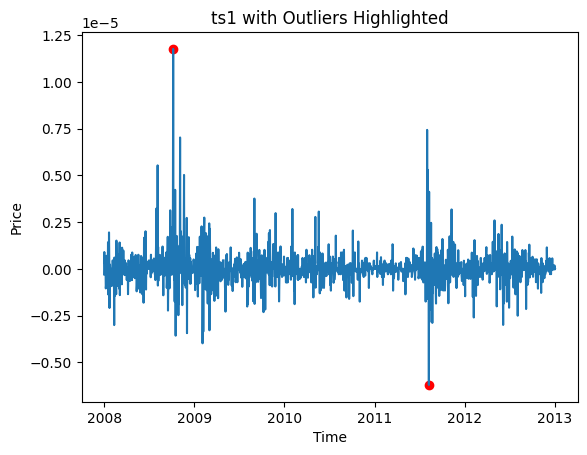

3


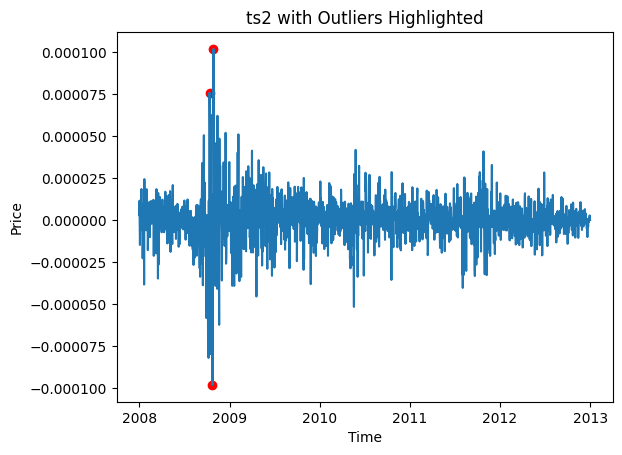

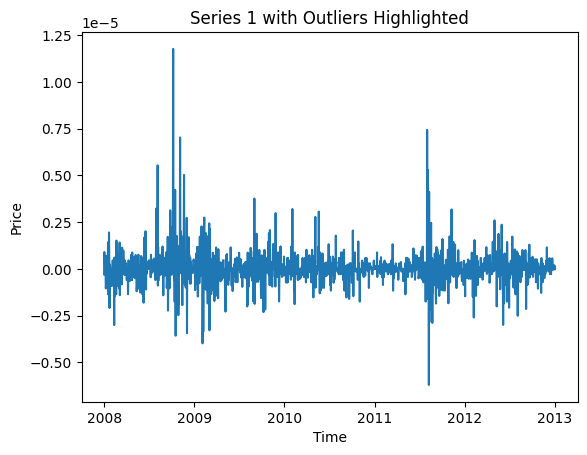

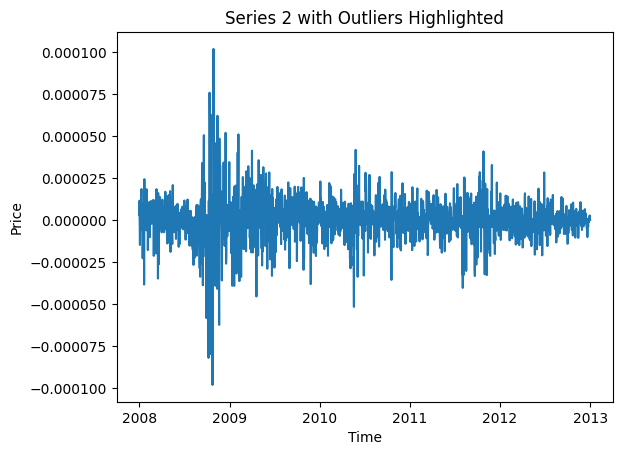

Intersection times:
DatetimeIndex([], dtype='datetime64[ns]', name='datetime', freq=None)
Series 1 non-NaN count: 1828
Series 2 non-NaN count: 1828
Series 1 outliers count: 2
Series 2 outliers count: 3
Intersection of outlier series count: 0


In [86]:
#cluster outlier detection method rt_1
co_1 = cluster_method(rt_1_d)
print(len(co_1))
plot_series_with_outliers(rt_1_d, co_1, 'ts1')

# cluster outlier detection method rt_2
co_2 = cluster_method(rt_2_d)

print(len(co_2))
plot_series_with_outliers(rt_2_d, co_2, 'ts2')

print_series_comparison_info(rt_1_d, rt_2_d, co_1, co_2)

In [ ]:
clean_df = pd.read_csv('clean_df.csv')
clean_df.set_index('datetime', inplace = True)
clean_df.index = pd.to_datetime(clean_df.index)
ts_1_imp = clean_df['ts1']
ts_2_imp = clean_df['ts2']

rt = np.log(clean_df/clean_df.shift(1))
rt.dropna(inplace=True)
rt_1 = rt['ts1']
rt_2 = rt['ts2']

analyse_seasonality(ts_1_imp, 'ts1', freq_list=['H', 'D', 'W'])
analyse_seasonality(ts_2_imp, 'ts2', freq_list=['H', 'D', 'W'])
spectral_analysis(rt_1, 'ts1', freq_list=['15T','30T','H', 'D', 'W'])
spectral_analysis(rt_2, 'ts2', freq_list=['15T','30T','H', 'D', 'W'])

analyse_distribution(rt)
plot_volatility_clustering(rt_1)
assess_volatility_clustering(rt_1)
plot_volatility_clustering(rt_2)
asses_volatility_clustering(rt_2)
analyse_outliers(rt_1, rt_2)
##apply stats to non imputed and imputed data
#non imputed
def load_data(filename):
    raw_df = pd.read_csv(filename, header=None)
    raw_df.columns = ['datetime', 'ts1', 'ts2']
    raw_df['datetime'] = pd.to_datetime(raw_df['datetime']-719529,unit='d').round('s')
    raw_df.set_index('datetime', inplace=True)
    return raw_df

filename = "Test_data.csv"
raw_df = load_data(filename)
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']
rt_o = np.log(raw_df/raw_df.shift(1))
# rt.dropna(inplace=True)
rt_1_o = rt_o['ts1']
rt_2_o = rt_o['ts2']


analyse_distribution(rt_o)
plot_volatility_clustering(rt_1_o)
assess_volatility_clustering(rt_1_o)
plot_volatility_clustering(rt_2_o)
asses_volatility_clustering(rt_2_o)
analyse_outliers(rt_1_o, rt_2_o)
